In [127]:

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('text.latex', preamble=r'''\usepackage{amsmath}
         \usepackage{physics}
         \usepackage{siunitx}
         ''')

In [128]:
theta = np.linspace(0, 2 * np.pi, num=200)
r = np.linspace(0, 2 * np.pi, num=200)
r, th = np.meshgrid(r, theta)

from ipywidgets import interact

def plot_both(sigma_x, sigma_y, true_A, true_phi):
    B_1 = 1/(2 * np.pi) / sigma_x / sigma_y 
    F = (- 1/2 *
            (    
                np.cos(true_phi)**2 / sigma_x**2 +
                np.sin(true_phi)**2 / sigma_y**2
            )
            +(    
                np.cos(theta)**2 / sigma_x**2+
                np.sin(theta)**2 / sigma_y**2
            )**(-1) *
            (    
                np.cos(true_phi)**2 * np.cos(theta)**2 / sigma_x**4 +
                np.sin(true_phi)**2 * np.sin(theta)**2 / sigma_y**4 +
                2* np.sin(true_phi) * np.sin(theta) * np.cos(true_phi) * np.cos(theta) / sigma_y**2 / sigma_x**2
            )
    )

    marginalized_posterior = B_1 * np.sqrt(2 * np.pi)*(    
            np.cos(theta)**2 / sigma_x**2+
            np.sin(theta)**2 / sigma_y**2
        )**(-1/2) + np.exp(true_A**2 * F)

    r_x = np.ones_like(r) * true_A
    th_x = np.ones_like(th) * true_phi
    arg = - 1/2 * (
        (r_x * np.cos(th_x) - r * np.cos(th))**2 / sigma_x**2+
        (r_x * np.sin(th_x) - r * np.sin(th))**2 / sigma_y**2)
    likelihood = B_1 * np.exp(arg)
    fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection='polar'), dpi=200)
    axs[0].contourf(th, r, likelihood)
    axs[1].plot(theta, marginalized_posterior)
    # axs[2].plot(theta, np.sum(likelihood, axis=1))
    axs[0].set_title('Likelihood')
    axs[1].set_title('Integral over $\\mathbb{R}$')
    # axs[2].set_title('Integral over $\\mathbb{R}^+$')
    for ax in axs:
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
    plt.tight_layout()

# interact(plot_both, 
#     sigma_x=(0.1,1,.1),
#     sigma_y=(0.1,1,.1), 
#     true_A=(0.1,4,.01),
#     true_phi=(0,2*np.pi,.05),
# )

In [129]:
%matplotlib inline

# plot_both(1.2, 1.8, 2.5, 1)
# plt.savefig('marginalization.pdf')

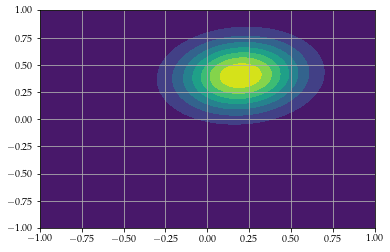

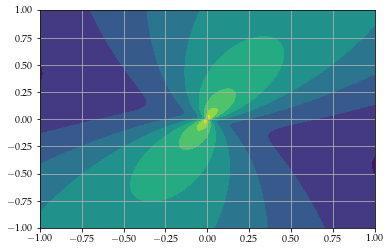

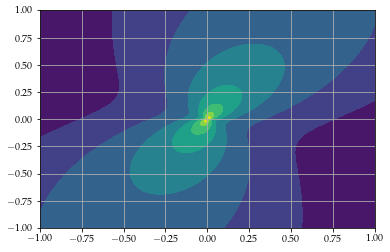

In [134]:
arg.shape

(100, 100, 2)